## Kết nối đến thư mục Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
project_path = '/content/drive/MyDrive/EdgeAIK03/M11K03_EdgeAI_MachineLearning_1'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/EdgeAIK03/M11K03_EdgeAI_MachineLearning_1


### Đọc Data và chia nhóm

#### Load data từ File đã trích xuất đặc trưng từ trước

In [116]:
import glob
import os
import numpy as np

labels = ['z_background', 'chainsaw']

data_lst = []
label_lst = []

for npy_path in glob.glob(r'IllegalLoggingDetection/features/*.npy'):
  x = np.load(npy_path)
  y = os.path.basename(npy_path).split('.')[0].lower()
  if y in labels:
    data_lst.append(x)
    label_lst.append(labels.index(y))

data_lst = np.array(data_lst)
label_lst = np.array(label_lst)

print(f'Tổng số mẫu: {data_lst.shape}')
print(f'Mẫu dữ liệu ({data_lst[0].shape}): {data_lst[0]} {label_lst[0]}')

Tổng số mẫu: (3163, 1680)
Mẫu dữ liệu ((1680,)): [0.83 0.79 0.8  ... 0.03 0.   0.01] 0


In [117]:
print(data_lst.shape, label_lst.shape)

(3163, 1680) (3163,)


In [118]:
import numpy as np
idx_nan = np.where(np.isnan(data_lst).any(axis=1))[0]
print(f'Hàng {idx_nan} chứa giá trị nan')
data_lst = np.delete(data_lst, idx_nan, axis=0)
label_lst = np.delete(label_lst, idx_nan, axis=0)
print(data_lst.shape, label_lst.shape)


Hàng [760] chứa giá trị nan
(3162, 1680) (3162,)


#### Chia tập dữ liệu thành tập Train (80%), Test (20%)

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(data_lst, label_lst, test_size=0.2, stratify=label_lst)

# Print status
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t y train shape: {}".format(y_test.shape, y_train.shape))

le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))
print(y_test_encoded.shape)
print(y_train_encoded.shape)

train_labels, train_counts = np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
print("Train label distribution:", dict(zip(train_labels, train_counts)))
print("Test label distribution:", dict(zip(test_labels, test_counts)))

X test shape: (633, 1680) 	 X train shape: (2529, 1680)
y test shape: (633,) 	 y train shape: (2529,)
(633, 2)
(2529, 2)
Train label distribution: {0: 2427, 1: 102}
Test label distribution: {0: 608, 1: 25}


### Tạo Model

#### Cấu hình Model

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

In [121]:
input_shape = 1680
output_shape = 2

In [122]:
# Total number of labels to predict (equal to the network output nodes)

model = Sequential()
model.add(Dense(256, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dropout(0.2))
model.add(Dense(output_shape, name='y_pred', activation='softmax'))

In [123]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ y_pred (Dense)                       │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Tạo Loss Function, Optimizer, Training

#### Thiết lập thông số Train

In [124]:
learning_rate = 0.001  # Tốc độ học
epochs = 500  # Số chu kỳ huấn luyện
batch_size = 32  # Số dữ liệu cho 1 batch

#### Huấn luyện

In [125]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

class EpochLogger(Callback):
    def __init__(self, display_step):
        super(EpochLogger, self).__init__()
        self.display_step = display_step

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_step == 0:
            print(f"Epoch {epoch + 1}/{self.params['epochs']} - loss: {logs['loss']:.4f}, accuracy: {logs['accuracy']:.4f}" + \
                  (f", val_loss: {logs['val_loss']:.4f}, val_accuracy: {logs['val_accuracy']:.4f}" if 'val_loss' in logs else ""))


early_stopping = EarlyStopping(
    monitor="val_loss",  # Theo dõi giá trị 'val_loss'
    patience=50,         # Số epoch chờ trước khi dừng
    verbose=1,           # Hiển thị thông báo khi dừng
    restore_best_weights=True  # Phục hồi trọng số tốt nhất
)

In [126]:
from tensorflow.keras.optimizers import Adam

epoch_logger = EpochLogger(display_step=5)
checkpoint = ModelCheckpoint(filepath="IllegalLoggingDetection/best_model.keras", monitor="val_loss", save_best_only=True, verbose=0)

opt = Adam(learning_rate=learning_rate) # Thuật toán tối ưu
model.compile(
    loss='categorical_crossentropy', # Function tính loss function
    metrics=['accuracy'], # hiển thị xác suất độ chính xác
    optimizer=opt)

In [127]:
history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    validation_split=0.2, verbose=0,
    batch_size=batch_size, callbacks=[checkpoint, epoch_logger, early_stopping], shuffle=True)

Epoch 5/500 - loss: 0.0797, accuracy: 0.9797, val_loss: 0.0441, val_accuracy: 0.9921
Epoch 10/500 - loss: 0.0461, accuracy: 0.9896, val_loss: 0.0274, val_accuracy: 0.9941
Epoch 15/500 - loss: 0.0470, accuracy: 0.9891, val_loss: 0.0197, val_accuracy: 0.9980
Epoch 20/500 - loss: 0.0464, accuracy: 0.9896, val_loss: 0.0649, val_accuracy: 0.9862
Epoch 25/500 - loss: 0.0431, accuracy: 0.9891, val_loss: 0.1311, val_accuracy: 0.9605
Epoch 30/500 - loss: 0.0733, accuracy: 0.9560, val_loss: 0.0716, val_accuracy: 0.9585
Epoch 35/500 - loss: 0.0704, accuracy: 0.9718, val_loss: 0.0494, val_accuracy: 0.9881
Epoch 40/500 - loss: 0.0469, accuracy: 0.9876, val_loss: 0.0397, val_accuracy: 0.9921
Epoch 45/500 - loss: 0.0738, accuracy: 0.9659, val_loss: 0.0569, val_accuracy: 0.9881
Epoch 50/500 - loss: 0.0391, accuracy: 0.9911, val_loss: 0.0414, val_accuracy: 0.9901
Epoch 55/500 - loss: 0.0384, accuracy: 0.9906, val_loss: 0.0410, val_accuracy: 0.9941
Epoch 60/500 - loss: 0.0746, accuracy: 0.9570, val_loss

#### Vẽ đồ thị quá trình huấn luyện

In [128]:
import matplotlib.pyplot as plt


# Hàm vẽ đồ thị lịch sử huấn luyện
def plot_training_history(history, step=5):
    """
    Vẽ đồ thị lịch sử huấn luyện của mô hình, hiển thị một số epoch nhất định.

    Tham số:
    - history: Kết quả lịch sử huấn luyện từ model.fit().
    - step: Khoảng cách giữa các epoch được hiển thị.
    """
    plt.figure(figsize=(12, 6))

    # Vẽ loss với khoảng cách epoch
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss', color='blue', linewidth=2)
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

    # Thêm chú thích
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

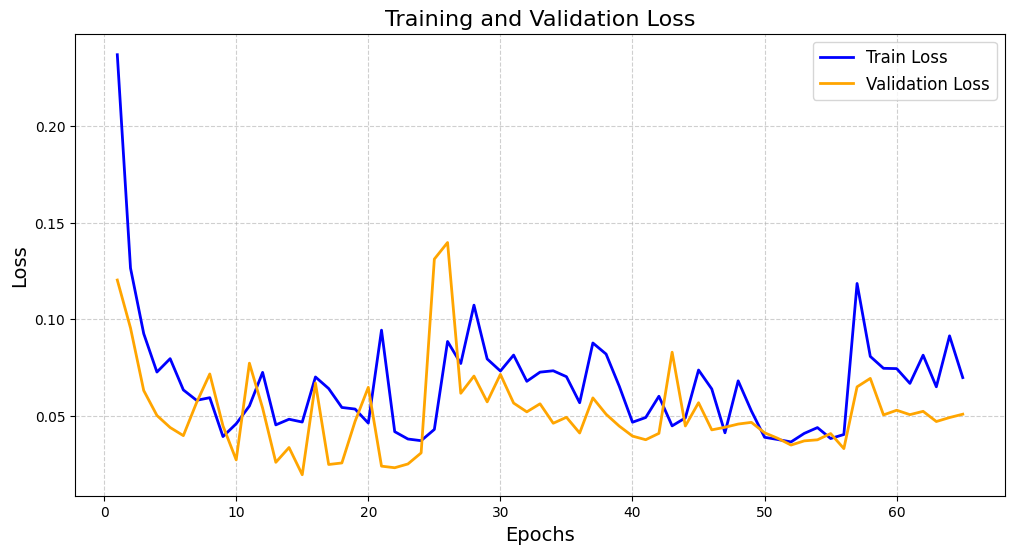

In [129]:
plot_training_history(history, step=10)

#### Đánh giá mô hình

In [130]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Vẽ confusion matrix.

    Tham số:
    - y_true: Nhãn thật (ground truth).
    - y_pred: Nhãn dự đoán từ mô hình.
    - class_names: Danh sách tên các phân lớp.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

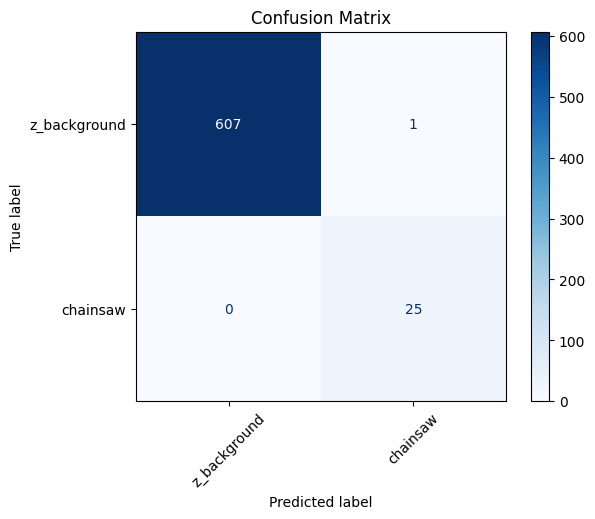

In [131]:
# Đánh giá hiệu năng mô hình nếu có tập validation
metrics = {}
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) # [0, 1, 0, 0, 0 ,0 ,0 ,0 ,0 ] => 1
y_trues = np.argmax(y_test_encoded, axis=1) # [0, 0, 1, 0, 0 ,0 ,0 ,0 ,0 ] => 2
# Add "pred" column
#test_meta['pred'] = yhat_probs

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

plot_confusion_matrix(y_trues, yhat_probs, labels)

In [132]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred, num_classes=2):
    """
    Đánh giá mô hình với các chỉ số phân loại chính: AUC, Precision, Recall, F1.

    Tham số:
    - y_true: numpy array, nhãn thực tế (integer).
    - y_pred: numpy array, nhãn dự đoán (integer).
    - num_classes: Số phân lớp (mặc định: 2).

    Trả về:
    - Một dictionary chứa các chỉ số đánh giá.
    """
    # Tính toán các chỉ số đánh giá
    weighted_precision = precision_score(y_true, y_pred, average="weighted")
    weighted_recall = recall_score(y_true, y_pred, average="weighted")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    classification_report_str = classification_report(y_true, y_pred)

    # Trả về các chỉ số
    return {
        "precision": weighted_precision,
        "recall": weighted_recall,
        "f1_score": weighted_f1,
        "classification_report": classification_report_str
    }

In [133]:
print(y_test_encoded.shape, y_probs.shape)

(633, 2) (633, 2)


In [134]:
evaluation_results = evaluate_model(np.argmax(y_test_encoded, axis=1), np.argmax(y_probs, axis=1), num_classes=2)

# Hiển thị kết quả đánh giá
print("Evaluation Results:")
print(f"Weighted Precision: {evaluation_results['precision']:.4f}")
print(f"Weighted Recall: {evaluation_results['recall']:.4f}")
print(f"Weighted F1-Score: {evaluation_results['f1_score']:.4f}")
print("Classification Report:\n", evaluation_results["classification_report"])

Evaluation Results:
Weighted Precision: 0.9985
Weighted Recall: 0.9984
Weighted F1-Score: 0.9984
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       608
           1       0.96      1.00      0.98        25

    accuracy                           1.00       633
   macro avg       0.98      1.00      0.99       633
weighted avg       1.00      1.00      1.00       633



#### Chạy thử mô hình

In [135]:
import random
idx = random.randint(0, X_test.shape[0])
print(f'y_target: {y_test_encoded[idx]} | y_predict: {model.predict(np.expand_dims(X_test[idx], axis=0), verbose=0).squeeze()}')

y_target: [1. 0.] | y_predict: [1.0e+00 3.1e-05]
